# General context

The [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) competition aims to enhance automated essay grading systems to support overburdened teachers, especially in underserved communities. It addresses the limitations of previous efforts by using a larger, more diverse dataset to improve scoring accuracy and fairness. Hosted by Vanderbilt University and The Learning Agency Lab, the competition seeks to develop open-source tools that provide timely feedback to students and integrate more effectively into real-world educational settings. This initiative represents a significant advancement in educational technology, promoting equitable access to reliable automated essay scoring.

In this notebook, I conducted some basic exploratory data analysis 

# Inclusion and global variables

In [1]:
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from settings.settings import (
LOCAL_STR,
DEBERTA_V3_CKPT,
MATPLOTBLUE,
SEED,
DEVICE,
configuration_builder, 
)

import pandas as pd 

## Set and define global configuration

In this section, I set up a configuration builder that utilizes the Python data class `ConfigurationSetting` to enhance the code's flexibility. This approach allows the code to run with specific configurations in dedicated environments. The instance of `ConfigurationSetting` created by the builder is used throughout the code, replacing hardcoded values.

In [2]:
configuration_item = configuration_builder(
    model_ckpt=DEBERTA_V3_CKPT,
    plot_color=MATPLOTBLUE,
    seed=SEED,
    device=DEVICE
)

# Load the data

Data comes from the Kaggle competition [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) and can be downloaded from the competition's page.

In [4]:
if not configuration_item.data_path:
    raise ValueError

train_ds = pd.read_csv(
    filepath_or_buffer=configuration_item.data_path / "train.csv"
)

# What about the scores ?

The [holistic rating for source-based writing](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf) uses a grading scale from 1 to 6 to assess essays based on mastery level. 

- **Score of 6**: Demonstrates clear and consistent mastery with minor errors. Shows outstanding critical thinking, effective use of evidence, coherent organization, skillful language use, and minimal grammar errors.
- **Score of 5**: Shows reasonably consistent mastery with occasional errors. Exhibits strong critical thinking, appropriate use of evidence, good organization, appropriate language use, and general freedom from major errors.
- **Score of 4**: Demonstrates adequate mastery with lapses in quality. Displays competent critical thinking, adequate use of evidence, general organization, and some language variety, but may have some errors.
- **Score of 3**: Indicates developing mastery with notable weaknesses. Shows inconsistent critical thinking, inadequate evidence use, limited organization, weak language use, and an accumulation of errors.
- **Score of 2**: Shows little mastery with serious weaknesses. Demonstrates weak critical thinking, insufficient evidence, poor organization, limited vocabulary, and frequent grammar errors.
- **Score of 1**: Reflects very little or no mastery with severe flaws. Lacks a clear point of view, provides little evidence, is disorganized, has fundamental vocabulary errors, and pervasive grammar issues.

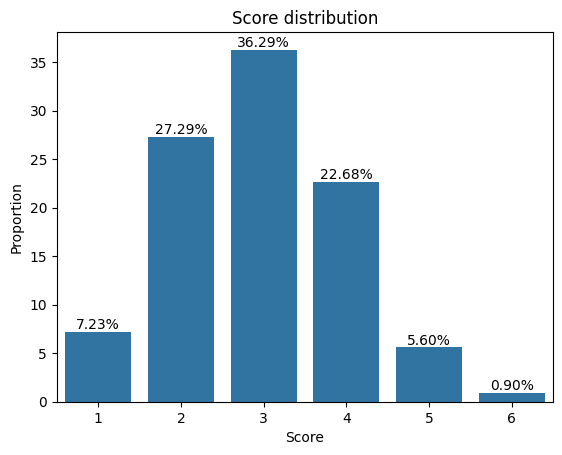

In [5]:
score_count = (
    train_ds["score"]
    .value_counts(normalize=True)
    .rename_axis("score")
    .reset_index(name="proportion")
)
score_count["proportion"] = score_count["proportion"] * 100

ax = sns.barplot(
    x="score",
    y="proportion",
    data=score_count,
    color=MATPLOTBLUE
)
ax.bar_label(container=ax.containers[0], fontsize=10, fmt="%.2f%%") 

plt.title("Score distribution")
plt.xlabel("Score")
plt.ylabel("Proportion")
plt.show()

del score_count

The dataset appears to have a distribution that is weighted towards less extreme scores, with a notable decline in the proportion of the highest values. This uneven distribution requires careful consideration during analytical modeling. Special techniques may be necessary to account for the imbalance and to ensure that the analysis is robust, particularly when predicting or interpreting the less represented extreme values.

At first glance, I would expect a model to struggle with distinguishing between grade 5 and grade 6 texts. Both categories exhibit high levels of critical thinking, appropriate use of evidence, good organization, and effective language use. Moreover, the extremely low proportion of essays receiving a score of 6 (0.90%) compared to those receiving a score of 5 (5.60%) indicates that grade 6 texts are rare. This scarcity provides a model with limited examples, making it difficult to learn the subtle differences between these high-performing categories.

# What about the text

Addressing the issue of sequence size in the context of natural language processing models, such as [Sentence-BERT](https://arxiv.org/abs/1908.10084), is critical due to the token limit restrictions imposed by these models. Typically, these models cap the number of tokens that can be processed in a single pass, often set at [512 tokens, or sometimes fewer](https://sbert.net/docs/pretrained_models.html). This constraint poses a significant challenge when attempting to encode longer texts, as it necessitates either the omission of content or the application of sophisticated strategies to manage longer sequences effectively (e.g., [via a text splitter](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/split_by_token/#sentencetransformers)). In scholarly discourse, this topic is particularly relevant as it underscores a limitation within state-of-the-art language models when confronted with lengthy documents. It opens up an area for methodological advancements and innovative techniques aimed at preserving the semantic richness of extensive texts without compromising the quality of the generated embeddings. Focusing on the sequence size involves exploring and refining these techniques, which may include partitioning the text into smaller, manageable units while ensuring minimal loss of contextual information. The implications of such methods are profound, impacting both the efficiency of computational processes and the fidelity of text interpretation, especially in domains where the precision of language is paramount. Let's observe the distribution of the text size.

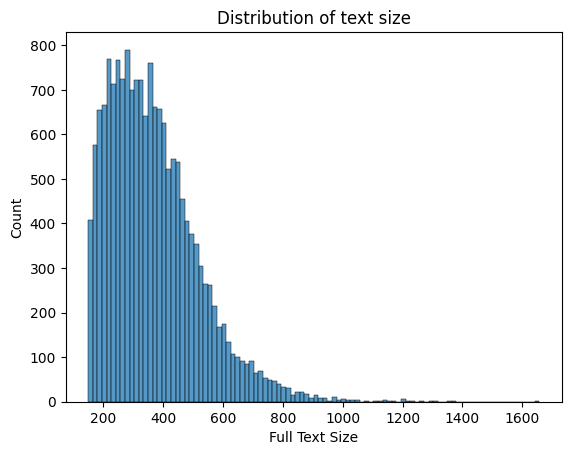

In [21]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")
full_text_size = train_ds.full_text.map(lambda x: len(x.split()))
sns.histplot(full_text_size) # type: ignore
plt.xlabel("Full Text Size")
plt.ylabel("Count")
plt.title("Distribution of text size")
plt.show()

The graph highlights a right-skewed distribution of text lengths in a dataset, with most texts falling between 200 to 400 units and a few significantly longer outliers. Multiple peaks suggest the presence of several preferred text lengths. Regarding a potential use of Sentence-BERT for modeling, while adept at producing semantically meaningful sentence embeddings, it may face challenges with these longer texts due to token limits causing memory and computational burdens, potential loss of context when texts are truncated, and inefficiencies in encoding lengthy sequences. This underscores the need for strategic text handling to ensure meaningful semantic encoding by Sentence-BERT, particularly for outlier texts that exceed typical length constraints. To circumvent these limitations, a methodology involving the segmentation of longer texts into individual sentences is proposed, thereby allowing Sentence-BERT to operate within its tokenization parameters while preserving the textual integrity. Such segmentation facilitates detailed semantic analysis of each sentence independently, with the subsequent synthesis of these analyses yielding a comprehensive understanding of the text's overarching semantic structure. Enhancing this segmentation approach, the introduction of overlap between consecutive text chunks is advocated. By ensuring that adjacent segments share a subset of sentences, this strategy aims to safeguard the continuity of information, particularly across segment boundaries. This overlapping ensures the retention of crucial context, which is paramount in the construction of a coherent narrative, particularly for extensive documents where interpretative nuances are intrinsically linked to the broader context.

# Conclusion

Through exploratory data analysis, this notebook has underscored several key challenges and considerations, such as the class imbalance in essay scores and the handling of text length constraints inherent in natural language processing models like Sentence-BERT. Furthermore, the analysis highlights the rarity and subtle nuances of grade 6 essays compared to grade 5 essays, which pose significant challenges for model training due to limited examples. Additionally, the token limitations of models like Sentence-BERT necessitate innovative strategies, such as text segmentation and overlapping chunks, to maintain the integrity and context of longer texts. These methodological advancements are crucial for ensuring that automated scoring systems can provide reliable and meaningful feedback.